This notebook is for creating the base ML model.

In [1]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)
test_df = df.copy()

Index(['datetime', 'location', 'busyness'], dtype='object')


In [3]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,7319643,2022-08-17 07:20:13.353111,2021-01-01 00:00:00,2021-10-24 19:00:00,2022-08-17 08:00:00,2023-06-09 21:00:00,2024-04-01 00:00:00,NaN
location,7319643.0,133.938008,1.0,67.0,135.0,201.0,265.0,76.660677
busyness,7319643.0,236.200568,1.0,52.0,135.0,296.0,5510.0,299.993109


In [4]:
# Clip the data to 4 standard deviations
max = df['busyness'].mean() + 4 * df['busyness'].std()
mean = df['busyness'].mean()
std = df['busyness'].std()
df['busyness'].clip(upper = max, inplace=True)
df['busyness'] = (df['busyness']-mean)/std


C:\Users\Daniel\AppData\Local\Temp\ipykernel_20492\3333773935.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['busyness'].clip(upper = max, inplace=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_20492\3333773935.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1436.1730031232487' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['busyness'].clip(upper = max, inplace=True)


In [5]:
df.shape

(7319643, 3)

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,7319643,2022-08-17 07:20:13.353111,2021-01-01 00:00:00,2021-10-24 19:00:00,2022-08-17 08:00:00,2023-06-09 21:00:00,2024-04-01 00:00:00,NaN
location,7319643.0,133.938008,1.0,67.0,135.0,201.0,265.0,76.660677
busyness,7319643.0,-0.013408,-0.78402,-0.614016,-0.337343,0.199336,4.0,0.927652


In [7]:
df.head()

,datetime,location,busyness
0,2021-01-01,3,-0.347343
1,2021-01-01,4,-0.007335
2,2021-01-01,5,-0.724019
3,2021-01-01,6,-0.664017
4,2021-01-01,7,0.856018


In [8]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01 -0.347343
4       2021-01-01 -0.007335
5       2021-01-01 -0.724019
6       2021-01-01 -0.664017
7       2021-01-01  0.856018


In [9]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [10]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path="base_model_z_scaling"
)
print('we made the predictor')

we made the predictor


In [11]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model_z_scaling'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       4.33 GB / 15.90 GB (27.2%)
Disk Space Avail:   2145.82 GB / 2794.50 GB (76.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 261 time

In [12]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.190421     900.459429         103.478849          7
1     SeasonalNaive  -1.328032       1.609081           6.585538          2
2               ETS  -1.810442     107.430325           6.553776          5
3  RecursiveTabular  -2.132342     785.464472         467.790350          3
4             Naive  -2.362041       5.955553           6.482178          1
5     DirectTabular  -4.381734      60.413096         247.906390          4
6             Theta  -4.510630      55.792335           6.080268          6


In [13]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                 mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
3       2024-01-01 23:00:00 -0.221244 -0.347543 -0.304187 -0.272924 -0.246212   
        2024-01-02 00:00:00 -0.407113 -0.540260 -0.494554 -0.461596 -0.433435   
        2024-01-02 01:00:00 -0.271828 -0.410230 -0.362719 -0.328461 -0.299188   
        2024-01-02 02:00:00 -0.331648 -0.474481 -0.425449 -0.390094 -0.359884   
        2024-01-02 03:00:00 -0.445039 -0.591777 -0.541405 -0.505083 -0.474048   
...                               ...       ...       ...       ...       ...   
110     2022-04-23 13:00:00 -0.782041 -0.810226 -0.800550 -0.793574 -0.787612   
        2022-04-23 14:00:00 -0.782509 -0.810698 -0.801021 -0.794044 -0.788081   
        2022-04-23 15:00:00 -0.782956 -0.811150 -0.801472 -0.794493 -0.788530   
        2022-04-23 16:00:00 -0.783053 -0.811252 -0.801571 -0.794591 -0.788627   
        2022-04-23 17:00:00 

In [18]:
# Because df was clipped need to make test data again out of df
test_df['busyness'] = (test_df['busyness']-mean)/std
test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="location",
    timestamp_column="datetime"
)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


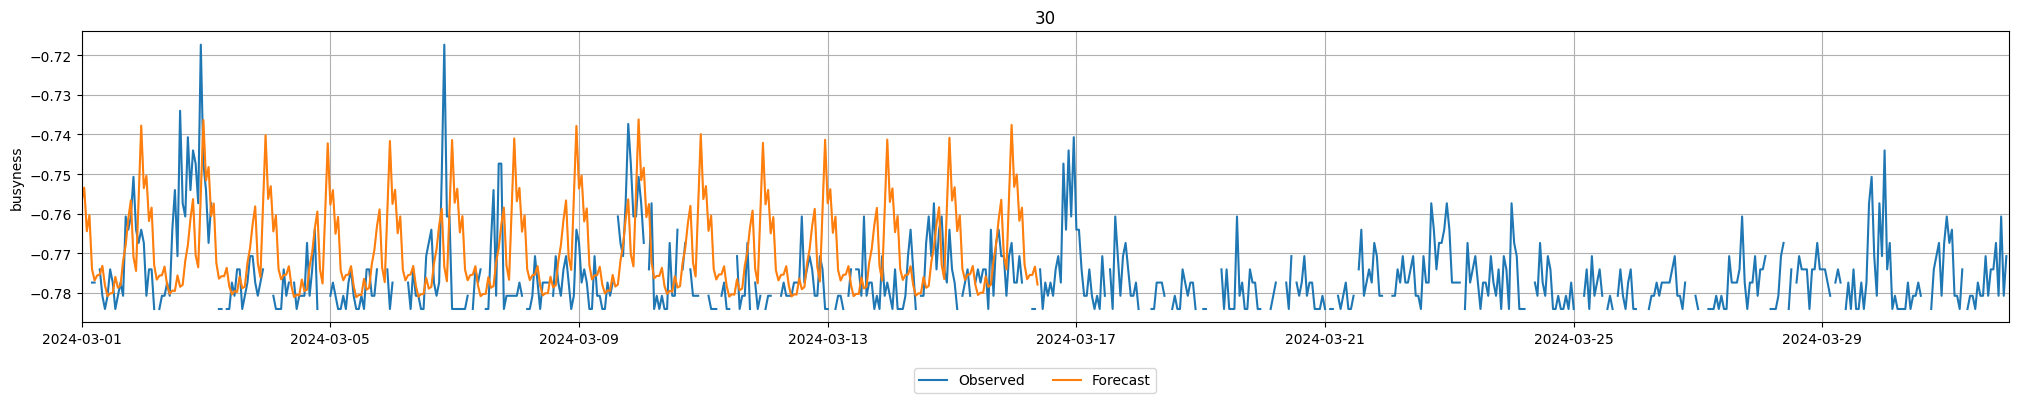

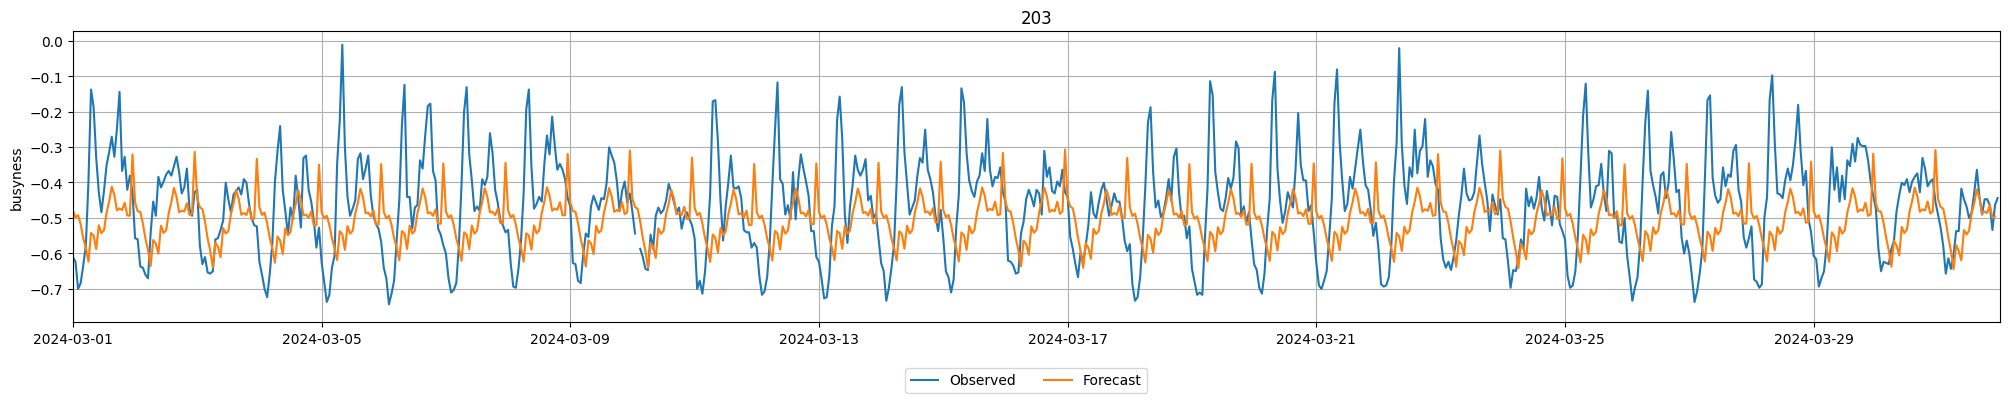

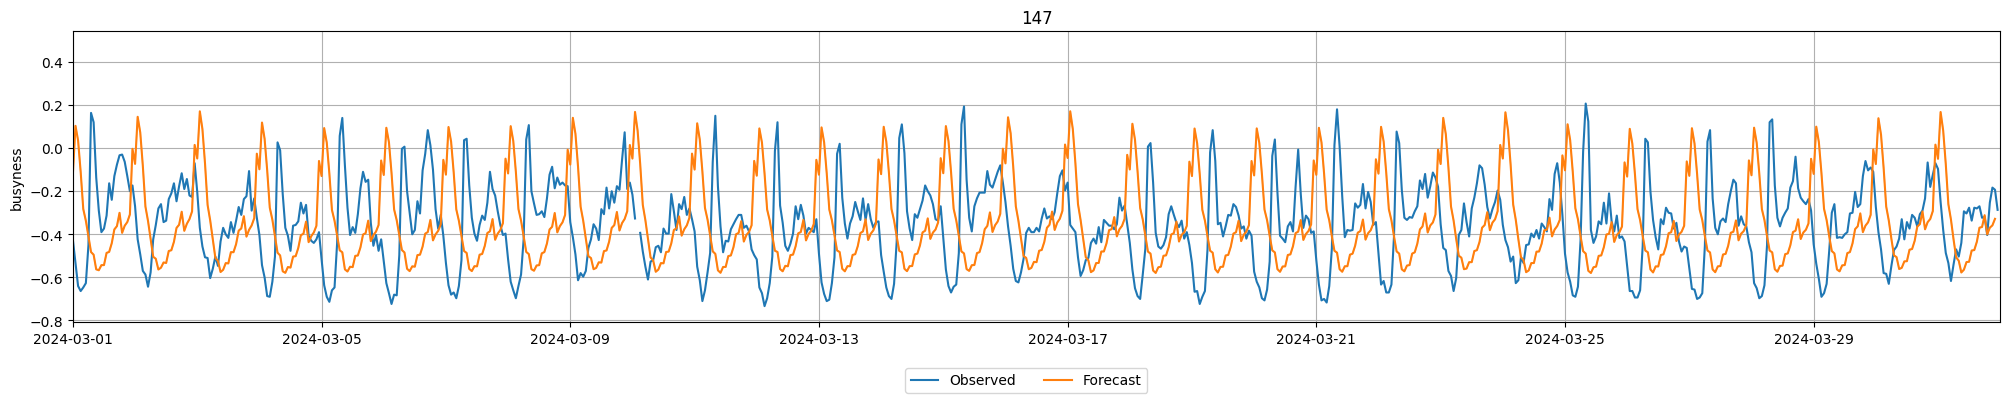

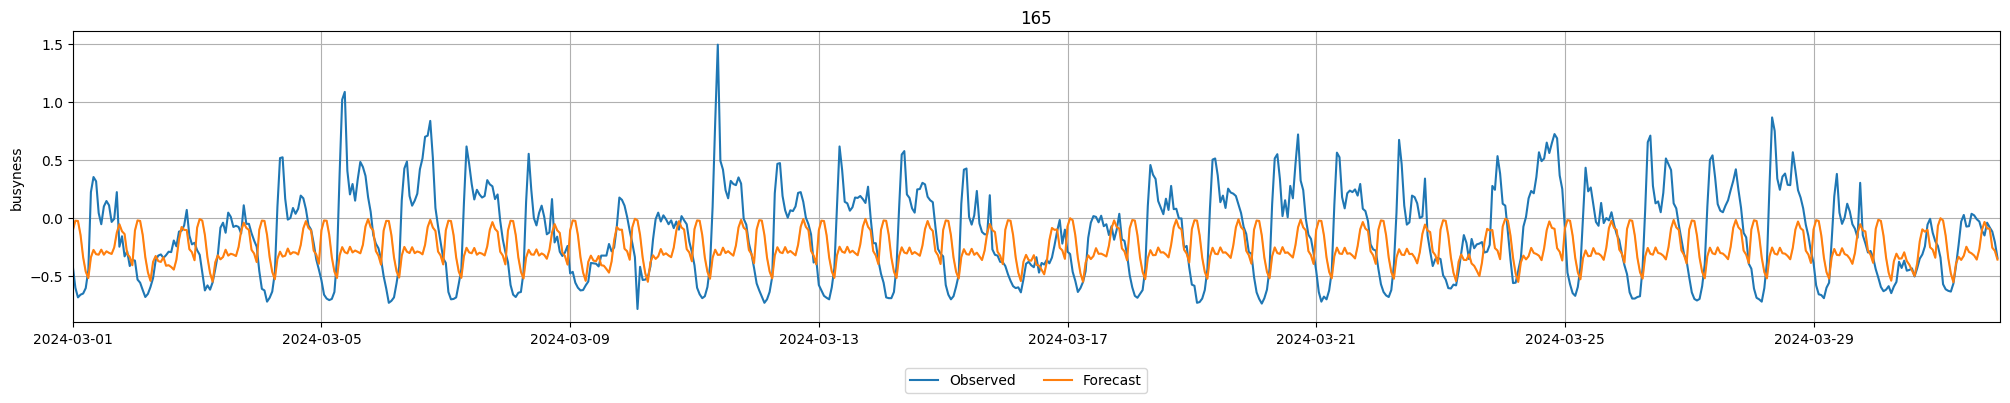

In [14]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
for i in range(4):
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=1)
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [15]:
ax = plot.gca()
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
ax.set_xlim([xmin, xmax])

(19783.0, 19813.999988425927)

In [16]:
plot.savefig("test-plot.png")

In [17]:
plt.show()

In [19]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -2.6907992089170714}